In [180]:
#Importing Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_validate

In [181]:
#Open datasets
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [182]:
#drop unnecessary columns
df_train.drop(['PassengerId','Name', 'Ticket','Cabin'], axis = 1, inplace = True)
df_test.drop(['Name', 'Ticket','Cabin'], axis = 1, inplace = True)

In [183]:
#DataSet Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [184]:
#DataSet Description
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [185]:
#DataSet
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Data Knowledge    

#### Passenger Class

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

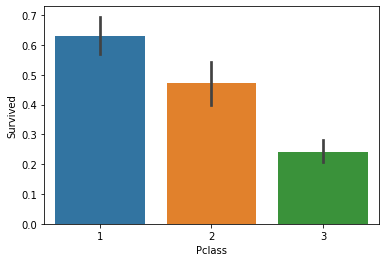

In [186]:
sns.barplot(x = 'Pclass', y = 'Survived', data = df_train)

We can clearly see that the people with higher class booked in the ship had a bigger chance to survive the accident.

Important metric for our Analysis.

#### Passenger Sex

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

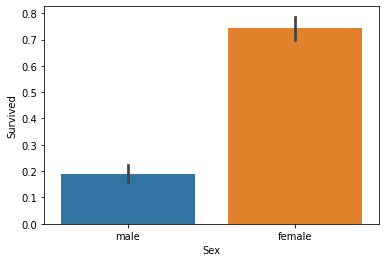

In [187]:
sns.barplot(x = 'Sex', y = 'Survived', data = df_train)

We clearly understand that the sex matters if you want to survive. This makes sense usually in this type of disasters the first to be evacuated are women and children.

As class that we see above, age will ke a key feature too.

Let's verify which ages in the male genre survived more with the PClass involved.

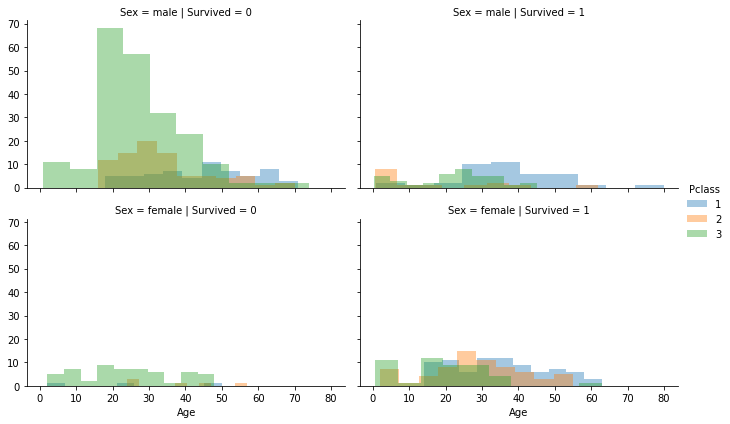

In [188]:
grid = sns.FacetGrid(df_train, col='Survived', row='Sex', hue = 'Pclass',aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.4, bins=10)
grid.add_legend()
plt.show()

We build two columns with survived and deceased, and what we can if we look to the female that died is that majority was from Class 3, the cheapest ticket. In the male section the same situation occurs.

So we have found for now 3 variables that are interesting for our model. Pclass, age and sex.

#### Age

We will create two different subsets to verify the distribution by sex in male and female passengers.

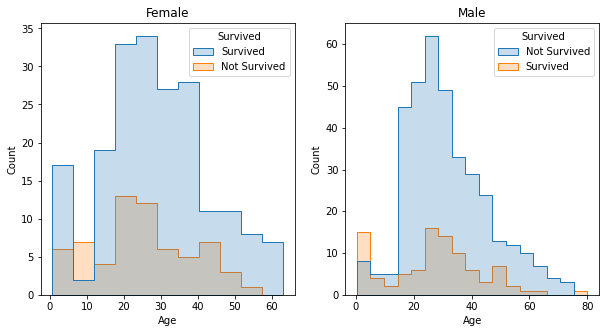

In [189]:
#subset sex = female
sex_female = df_train[df_train['Sex'] == 'female']
sex_female_cat = sex_female.copy()
sex_female_cat['Survived'] = sex_female_cat['Survived'].map({0:'Not Survived', 1: 'Survived'})

#subset sex = male
sex_male = df_train[df_train['Sex'] == 'male']
sex_male_cat = sex_male.copy()
sex_male_cat['Survived'] = sex_male_cat['Survived'].map({0:'Not Survived', 1: 'Survived'})

fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (10,5))
female = sns.histplot(x = sex_female_cat['Age'], hue = 'Survived', data = sex_female_cat, element = 'step', ax = ax[0])
female.set_title('Female')
male = sns.histplot(x = sex_male_cat['Age'], hue = 'Survived', data = sex_male_cat, element = 'step', ax = ax[1])
male.set_title('Male')
plt.show()

First we can see that died more males than females as expected. An the majority of deaths were between 20 and 50 for both sexes.

#### Sibsp & Parch - Family Members

We will verify if people that had relatives such as siblings (sibsp) or parents (parch) have more proabibility or not to survive.

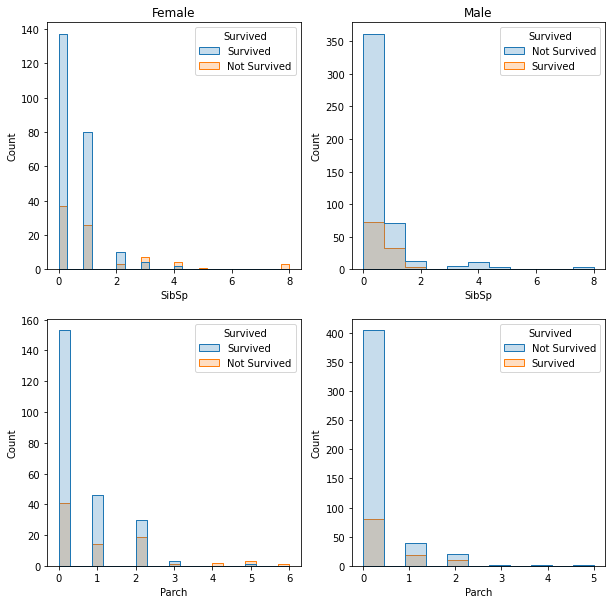

In [190]:
#subset sex = female
sex_female = df_train[df_train['Sex'] == 'female']
sex_female_cat = sex_female.copy()
sex_female_cat['Survived'] = sex_female_cat['Survived'].map({0:'Not Survived', 1: 'Survived'})

#subset sex = male
sex_male = df_train[df_train['Sex'] == 'male']
sex_male_cat = sex_male.copy()
sex_male_cat['Survived'] = sex_male_cat['Survived'].map({0:'Not Survived', 1: 'Survived'})

fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
female_sibsp = sns.histplot(x = sex_female_cat['SibSp'], hue = 'Survived', data = sex_female_cat, element = 'step', ax = ax[0][0])
female_sibsp.set_title('Female')
male_sisp = sns.histplot(x = sex_male_cat['SibSp'], hue = 'Survived', data = sex_male_cat, element = 'step', ax = ax[0][1])
male_sisp.set_title('Male')
female_parch = sns.histplot(x = sex_female_cat['Parch'], hue = 'Survived', data = sex_female_cat, element = 'step', ax = ax[1][0])
male_parch = sns.histplot(x = sex_male_cat['Parch'], hue = 'Survived', data = sex_male_cat, element = 'step', ax = ax[1][1])

We can see a pattern mostly in the men section, Men withou relatives had a big probability of dying. However for both sex as soon as the number of relatives starts to increase, the probability of survival is bigger than probability of dying.

#### Fare

We already conclude that the Class is one of the features that contributes for the survival or not of the person.
Fare is price of the ticket, so I believe that the result will be similar.

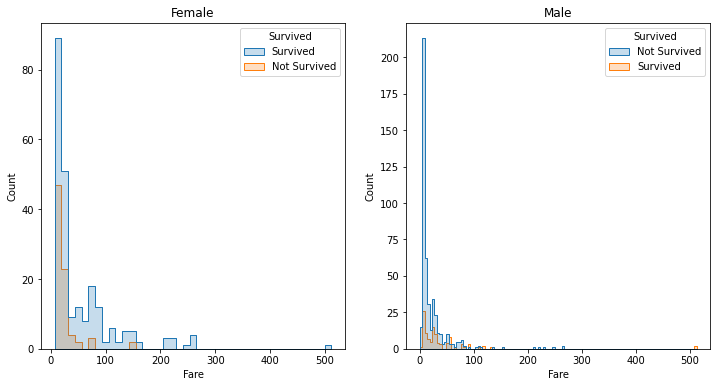

In [191]:
#subset sex = female
sex_female = df_train[df_train['Sex'] == 'female']
sex_female_cat = sex_female.copy()
sex_female_cat['Survived'] = sex_female_cat['Survived'].map({0:'Not Survived', 1: 'Survived'})

#subset sex = male
sex_male = df_train[df_train['Sex'] == 'male']
sex_male_cat = sex_male.copy()
sex_male_cat['Survived'] = sex_male_cat['Survived'].map({0:'Not Survived', 1: 'Survived'})

fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
female_sibsp = sns.histplot(x = sex_female_cat['Fare'], hue = 'Survived', data = sex_female_cat, element = 'step', ax = ax[0])
female_sibsp.set_title('Female')
male_sisp = sns.histplot(x = sex_male_cat['Fare'], hue = 'Survived', data = sex_male_cat, element = 'step', ax = ax[1])
male_sisp.set_title('Male')
plt.show()

We concluede that for both sex, when the fare is increasing the probability of survival is bigger too. We found another key feature for our analysis.

#### Embarked

Is the Port of embarkation a key feature ? Should we keep it?

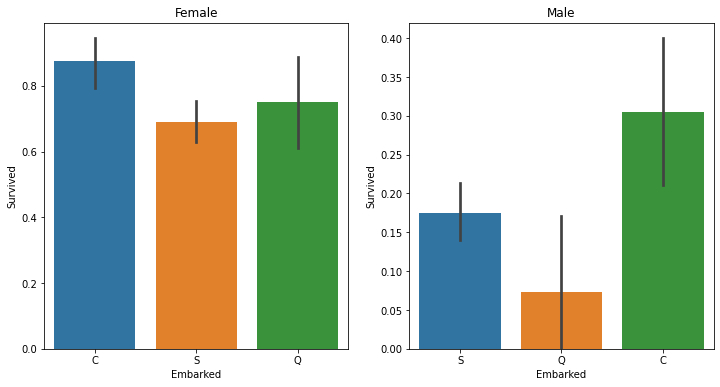

In [192]:
#subset sex = female
sex_female = df_train[df_train['Sex'] == 'female']
sex_female_cat = sex_female.copy()


#subset sex = male
sex_male = df_train[df_train['Sex'] == 'male']
sex_male_cat = sex_male.copy()


fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
female_sibsp = sns.barplot(x = sex_female_cat['Embarked'], y = 'Survived', data = sex_female_cat, ax = ax[0])
female_sibsp.set_title('Female')
male_sisp = sns.barplot(x = sex_male_cat['Embarked'], y = 'Survived', data = sex_male_cat,ax = ax[1])
male_sisp.set_title('Male')
plt.show()

And It is, the people that embarked in Port of Cherbourg have an higher probability of survival.

I will not say that the Port is the cause however I feel that the people that embark in each could have different wealth, can be younger. We will verify the fare mean for every port.

Let's verify.

In [193]:
d = {}
for port in ['S','C','Q']:
    x = df_train[df_train['Embarked'] == port]
    d[port] = x['Fare'].mean() 
print(d)

{'S': 27.079811801242233, 'C': 59.95414404761905, 'Q': 13.276029870129872}


And we have our confirmation, people that embark in Cherbourg are wealthy than the other Ports, that's why they have more probability to survive.

##### Conclusion

Most of the variables are important to our analysis, with the exception of PassengerID, Ticket & Cabin that were removed.

We conclude that age, sex, families and wealth will be key features to feed our model.

In the next chapter we will remove columns, add columns, feature engineering and fill NaN values.

In [194]:
df_test.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

## Data PreProcessing

#### NaN Values

In [195]:
df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

##### Embarked

We have only 2 missing values, so we will use SimpleImputer to impute the most frequent value.

In [196]:
from sklearn.impute import SimpleImputer

impute_mode = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

imputer = impute_mode.fit(df_train[['Embarked']])

df_train['Embarked'] = imputer.transform(df_train[['Embarked']])

df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

In [197]:
from sklearn.impute import SimpleImputer

impute_mode = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

imputer = impute_mode.fit(df_test[['Embarked']])

df_test['Embarked'] = imputer.transform(df_test[['Embarked']])

imputer_fare = impute_mode.fit(df_test[['Fare']])

df_test['Fare'] = imputer_fare.transform(df_test[['Fare']])

df_test.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            0
Embarked        0
dtype: int64

##### Age

I can think in some ways to impute this values, maybe mean (but this will remove representitivity from different ages (younger and elder), KNN Imputer could be a solution too however we have a lot of categorical variables and this will be a bias imputer too.

So I decide to apply random values to the Age column, that can vary from the 1st quartile (25%) to 3º quartile (75%) (Edge of the boxes) of the age of people present in the ship.

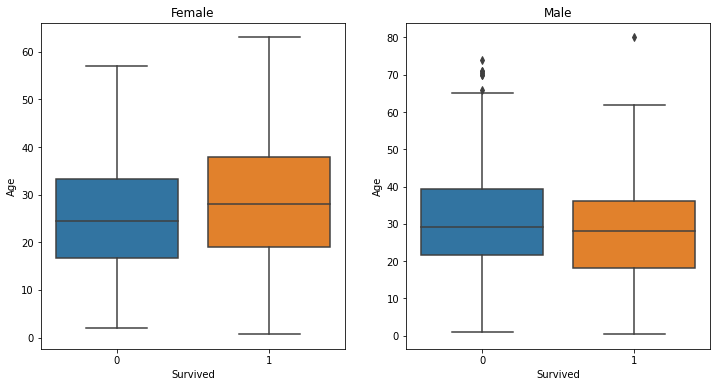

In [198]:
#subset sex = female
sex_female = df_train[df_train['Sex'] == 'female']
sex_female_cat = sex_female.copy()


#subset sex = male
sex_male = df_train[df_train['Sex'] == 'male']
sex_male_cat = sex_male.copy()


fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (12,6))
female_sibsp = sns.boxplot(x = 'Survived', y = sex_female_cat['Age'], data = sex_female_cat, ax = ax[0])
female_sibsp.set_title('Female')
male_sisp = sns.boxplot(x = 'Survived', y = sex_male_cat['Age'], data = sex_male_cat,ax = ax[1])
male_sisp.set_title('Male')
plt.show()

In [199]:
#We calculate the lower and upper limit from the Boxplot distribution
q75, q25 = np.percentile(df_train['Age'].dropna(), [75 ,25])

#Replace NaN Valeus by random number betwee
df_train['Age'] = df_train['Age'].fillna(np.random.randint(q25,q75))

df_train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [200]:
#We calculate the lower and upper limit from the Boxplot distribution
q75, q25 = np.percentile(df_train['Age'].dropna(), [75 ,25])

#Replace NaN Valeus by random number betwee
df_test['Age'] = df_test['Age'].fillna(np.random.randint(q25,q75))

df_test.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

#### Adding Columns

In [201]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Looking to the dataset above we will introduce a new column 'Family' that will be the sum of SibSp + Parch there's no need to have two columns we can perfectly add one to another and simplify it with family.

And after it we will drop the two columns.

In [202]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_train.drop(['SibSp','Parch'], axis = 1 , inplace = True)
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


#### OneHotEncoder

In [203]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In this chapter we will OneHotEncode the columns Embarked & Sex.

Note for the following, you can use get_dummies for embarked too, but not label encoder or even a mapping function. If you label for this three categories, we'll have something like 1,2,3, and the models that will analyse the data will establish a relationship of proximity of 1 to 2 for example and this is not necessarily true.


In [204]:
from sklearn.preprocessing import OneHotEncoder

#Use a sparse formatting to save memory
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

df_train_encoded = pd.DataFrame(encoder.fit_transform(df_train[['Sex','Embarked']]))

#get the name of the original columns
df_train_encoded.columns = encoder.get_feature_names_out(['Sex','Embarked'])

df_train.drop(['Sex','Embarked'] ,axis=1, inplace=True)

df_train = pd.concat([df_train, df_train_encoded ], axis=1)

df_train

,Survived,Pclass,Age,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,1,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,71.2833,1,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,7.9250,0,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,53.1000,1,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,8.0500,0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,0,0.0,1.0,0.0,0.0,1.0
887,1,1,19.0,30.0000,0,1.0,0.0,0.0,0.0,1.0
888,0,3,29.0,23.4500,3,1.0,0.0,0.0,0.0,1.0
889,1,1,26.0,30.0000,0,0.0,1.0,1.0,0.0,0.0


#### FeatureEngineering

In [205]:
df_train.isna().sum()

Survived      0
Pclass        0
Age           0
Fare          0
FamilySize    0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

We will feature engineering the columns Age & Engineering.

Note: We want that the application of feature engineering will be representative so what we will do it's divide the dataset in 4 portions of 25% of representativity, if we don't do that the model will be bias towards the lowest representative 'classes' that will provoke innacurity when to predict the target labels.

We will calculate the 1º and 3ª quartile and the median.

AGE!

In [206]:
#Passing all the values from float to int
df_train['Age'] = df_train['Age'].astype('int')

#Find the 1st and 3rd quartile
q25, q75 = np.quantile(df_train['Age'], [0.25,0.75])

#Find the median of the distribution
median_age = df_train['Age'].median()

#Find the maximum 
max_age = df_train['Age'].max()

#Find the minimum
min_age = df_train['Age'].min()

#Define the limits for the interval with 4 bins. 
#Note: We consider the lowest as -1, just because we transform the floats to int and babies with 0.2 time of life are going 0, and for us to be able
#to gather the 0, we have to consider -1 or any other negative number
bins = [min_age-1, q25, median_age, q75, max_age + 1]

#Define the labels
labels = [0,1,2,3]

#Use pd.cut() to transform the bin values to the discrete intervals
df_train['Age Range'] = pd.cut(df_train['Age'], labels = labels, bins = bins)

#Drop the Age column
df_train.drop('Age', axis = 1, inplace = True)

df_train.isna().sum()

Survived      0
Pclass        0
Fare          0
FamilySize    0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Age Range     0
dtype: int64

Fare

In [207]:
#Find the 1st and 3rd quartile
q25, q75 = np.quantile(df_train['Fare'], [0.25,0.75])

#Find the median of the distribution
median_age = df_train['Fare'].median()

#Find the maximum 
max_age = df_train['Fare'].max()

#Find the minimum
min_age = df_train['Fare'].min()

#Define the limits for the interval with 4 bins
#As the bins don't include the minimum and maximum range for the feature we assign -1 & +1 to be sure that the algorythm consider this
bins = [min_age-1, q25, median_age, q75, max_age+1]

#Define the labels
labels = [0,1,2,3]

#Use pd.cut() to transform the bin values to the discrete intervals
df_train['Fare Range'] = pd.cut(df_train['Fare'], labels = labels, bins = bins)

# #Drop the Age column
df_train.drop('Fare', axis = 1, inplace = True)

df_train.isna().sum()

Survived      0
Pclass        0
FamilySize    0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Age Range     0
Fare Range    0
dtype: int64

In [208]:
df_train['Age Range'] = df_train['Age Range'].astype('int')
df_train['Fare Range'] = df_train['Fare Range'].astype('int')

Now we are in conditions to build and feed the models of our choosing with data that we have.

If you look to the table only 'Survived' the target variable and PClass didn't suffer any type of modification.

Let's now choose and build our models.

In [209]:
df_train.head()

,Survived,Pclass,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age Range,Fare Range
0,0,3,1,0.0,1.0,0.0,0.0,1.0,0,0
1,1,1,1,1.0,0.0,1.0,0.0,0.0,3,3
2,1,3,0,1.0,0.0,0.0,0.0,1.0,1,1
3,1,1,1,1.0,0.0,0.0,0.0,1.0,2,3
4,0,3,0,0.0,1.0,0.0,0.0,1.0,2,1


## Training Models

#### Divide the Data

In [210]:
#Divide the dataset into data to analyse and target variable
X = df_train.drop('Survived', axis = 1)
y = df_train['Survived']

In [211]:
from sklearn.model_selection import train_test_split

#Divide the df_train into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Train the models

We will test the following models,

- Logistic Regression
- KNN
- Support Vectors Classifier
- Random Forest Classifier
- Extreme Gradient Boosting - XGB

You could analyse other models too, NBGaussian for example. However I feel that we will get good results with this models.

In [212]:
'''Models'''

#Define your models inside a list, dont'forget that this should be a tuple, with the name and the model that you want to test
models = [
          ('LogReg', LogisticRegression(max_iter=1000)), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('XGB', XGBClassifier())
        ]

'''Accuracy'''

#In this chapter you will focus in the accuracy metrics that you want to access
#We will access the most significant f1score,recall,precission, roc_auc, and accuracy

scoring_metrics = ['accuracy']

metrics_estimator = {}

#Initialize with the index of the metrics that you want to evaluate our model

dict_metrics = pd.DataFrame(index = ['f1_score','precision','recall','auc_score','accuracy'])

#We will apply kfold in 5 splits (default value) and cross validation too

for model_name, model in models:
    #Initiate KFold
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
    
    #Perform a cross validate (this one will record fit/score times
    #Don't forget that we will use kfold as our cv, logic that we will have cv = 5 as we chose 5 splits.
    cv = cross_validate(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    
    #Fit the model to the data
    model_fit = model.fit(X_train, y_train)
    
    #Predict X_test
    y_pred = model_fit.predict(X_train)
    
    dict_metrics[model_name] = [np.round(f1_score(y_train, y_pred),2), np.round(precision_score(y_train, y_pred),2), np.round(recall_score(y_train, y_pred),2),
                              np.round(roc_auc_score(y_train, y_pred),2), np.round(accuracy_score(y_train, y_pred),2)]
    
dict_metrics

,LogReg,RF,KNN,SVM,XGB
f1_score,0.72,0.82,0.77,0.74,0.81
precision,0.75,0.90,0.83,0.80,0.90
recall,0.69,0.75,0.72,0.68,0.74
auc_score,0.78,0.85,0.82,0.79,0.85
accuracy,0.80,0.87,0.84,0.82,0.87


If we analyse the results, we will discard SVM already, not only because it has the lowest accuracy, but the recall is very small (lower recall means that the model will predict that the person died even when we know that survived).

We will not establish in this analysis with a Recall/Precision tradeoff, just because it depends of the primer objective of this. Imagine that we want to preview if some person is dead with our model, we'll want an higher precision, but imagine that we only want to admit women and children in a boat, we want a higher recall to do this.

### Fine Tuning the models

#### Random Forest Classifier

In [213]:
from sklearn.model_selection import RandomizedSearchCV

params = { 
    'n_estimators': [50, 100, 200]}

rf_clf = RandomForestClassifier()

kfold = KFold(n_splits = 3, shuffle = True, random_state = 42)

rf_random_search = RandomizedSearchCV(rf_clf, param_distributions = params, scoring = 'accuracy', cv = kfold)

rf_random_search.fit(X_train, y_train)

y_pred_train = rf_random_search.best_estimator_.predict(X_train)

print(f'Train DataSet Precision Score : {np.round(precision_score(y_train, y_pred_train),2)}')

print(f'Train DataSet Recall Score : {np.round(recall_score(y_train, y_pred_train),2)}')

print(f'Train DataSet F1 Score : {np.round(f1_score(y_train, y_pred_train),2)}')

print(f'Train DataSet Accuracy Score : {np.round(accuracy_score(y_train, y_pred_train),2)}')

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Train DataSet Precision Score : 0.91
Train DataSet Recall Score : 0.74
Train DataSet F1 Score : 0.81
Train DataSet Accuracy Score : 0.87


#### KNN

In [214]:
from sklearn.model_selection import RandomizedSearchCV

#Alternativetly we can use Randomized Search if we have bigger datasets with some params to try

params = {'n_neighbors' : np.arange(1,10,1), 'p' : [1,2], 'weights':['uniform', 'distance']}

knn_grid = KNeighborsClassifier()

kfold = KFold(n_splits = 3, shuffle = True, random_state = 42)

knn_random_search = RandomizedSearchCV(knn_grid, param_distributions = params, scoring = 'accuracy',cv = kfold)

knn_random_search.fit(X_train, y_train)

knn_random_search.best_params_

y_pred_train = knn_random_search.best_estimator_.predict(X_train)

print(f'Train DataSet Precision Score : {np.round(precision_score(y_train, y_pred_train),2)}')

print(f'Train DataSet Recall Score : {np.round(recall_score(y_train, y_pred_train),2)}')

print(f'Train DataSet F1 Score : {np.round(f1_score(y_train, y_pred_train),2)}')

print(f'Train DataSet Accuracy Score : {np.round(accuracy_score(y_train, y_pred_train),2)}')

Train DataSet Precision Score : 0.86
Train DataSet Recall Score : 0.67
Train DataSet F1 Score : 0.75
Train DataSet Accuracy Score : 0.83


#### XGB

In [215]:
from sklearn.model_selection import RandomizedSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.3,0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7]
        }

xgb_clf = XGBClassifier()

kfold = KFold(n_splits = 3, shuffle = True, random_state = 42)

xgb_random_search = RandomizedSearchCV(xgb_clf, param_distributions = params, scoring = 'accuracy', cv = kfold)

xgb_random_search.fit(X_train, y_train)

xgb_random_search.best_params_

y_pred_train = xgb_random_search.best_estimator_.predict(X_train)

print(f'Train DataSet Precision Score : {np.round(precision_score(y_train, y_pred_train),2)}')

print(f'Train DataSet Recall Score : {np.round(recall_score(y_train, y_pred_train),2)}')

print(f'Train DataSet F1 Score : {np.round(f1_score(y_train, y_pred_train),2)}')

print(f'Train DataSet Accuracy Score : {np.round(accuracy_score(y_train, y_pred_train),2)}')

Train DataSet Precision Score : 0.85
Train DataSet Recall Score : 0.61
Train DataSet F1 Score : 0.71
Train DataSet Accuracy Score : 0.81


Hyperparameter tuning is not able to make the models better so we will use the default values that we used at first. 

So let's verify what type of predictions our model is capable to do?

#### Validate the model

In [223]:
'''Models'''

#Define your models inside a list, dont'forget that this should be a tuple, with the name and the model that you want to test
models = [
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('XGB', XGBClassifier())
        ]

'''Accuracy'''

#In this chapter you will focus in the accuracy metrics that you want to access
#We can access the most significant f1score,recall,precission, roc_auc, and accuracy

scoring_metrics = ['accuracy']

#Initialize with the index of the metrics that you want to evaluate our model

dict_metrics_test = pd.DataFrame(index = ['f1_score','precision','recall','auc_score','accuracy'])

#We will apply kfold in 5 splits (default value) and cross validation too

for model_name, model in models:
    #Initiate KFold
    kfold = KFold(n_splits = 10, shuffle = True, random_state = 42)
    
    #Perform a cross validate (this one will record fit/score times
    #Don't forget that we will use kfold as our cv, logic that we will have cv = 5 as we chose 5 splits.
    cv = cross_validate(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    
    #Fit the model to the data
    model_fit = model.fit(X_train, y_train)
    
    #Predict X_test
    y_pred = model_fit.predict(X_test)
    
    dict_metrics_test[model_name] = [np.round(f1_score(y_test, y_pred),2), np.round(precision_score(y_test, y_pred),2), np.round(recall_score(y_test, y_pred),2),
                              np.round(roc_auc_score(y_test, y_pred),2), np.round(accuracy_score(y_test, y_pred),2)]
    
dict_metrics_test

,RF,KNN,XGB
f1_score,0.74,0.77,0.76
precision,0.80,0.78,0.80
recall,0.69,0.76,0.72
auc_score,0.78,0.80,0.80
accuracy,0.80,0.81,0.81


With our test dataset we achieve a 81% of accuracy with the XGB and KNN.

We will use this 2 to evaluate feed more data into the dataset.

## Conclusion

We achieved 87% of accuracy with the train dataset for XGB and RandomForestClassifier.

We tried to fine tune the model, but we were not able to achieve better results with our training dataset.

Finally we feed our X_test to the model just to verify the accuracy that we achieved and we got 81% not bad. We have a small dataset to test, around 170 data entries, what is small enough.

Now as we have this results we are confident that the model will be good enough to be fed with the Test DataSet from Kaggle.